In [ ]:
!pip install transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
import pandas as pd
from torch.utils.data import TensorDataset, random_split
import matplotlib.pyplot as plt
import torch.nn.functional as nnf

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# Acculmating the attention scores of BERT with Fine tuning

In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [ ]:
from transformers import *
from torch.utils.data import TensorDataset, random_split, SequentialSampler,DataLoader, RandomSampler
import pandas as pd
import numpy as np
from collections import defaultdict
# (logits, hidden_states, attentions)
import seaborn as sns; sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Get attention function for a certain sentence

In [ ]:
import os
import torch
from collections import defaultdict

def get_attention(model, model_type, tokenizer, sentence_a, sentence_b=None, include_queries_and_keys=False):
    """Compute representation of attention to pass to the d3 visualization
    Args:
        model: pytorch-transformers model
        model_type: type of model. Valid values 'bert', 'gpt2', 'xlnet', 'roberta'
        tokenizer: pytorch-transformers tokenizer
        sentence_a: Sentence A string
        sentence_b: Sentence B string
        include_queries_and_keys: Indicates whether to include queries/keys in results
    Returns:
      Dictionary of attn representations with the structure:
      {
        'all': All attention (source = AB, target = AB)
        'aa': Sentence A self-attention (source = A, target = A) (if sentence_b is not None)
        'bb': Sentence B self-attention (source = B, target = B) (if sentence_b is not None)
        'ab': Sentence A -> Sentence B attention (source = A, target = B) (if sentence_b is not None)
        'ba': Sentence B -> Sentence A attention (source = B, target = A) (if sentence_b is not None)
      }
      where each value is a dictionary:
      {
        'left_text': list of source tokens, to be displayed on the left of the vis
        'right_text': list of target tokens, to be displayed on the right of the vis
        'attn': list of attention matrices, one for each layer. Each has shape [num_heads, source_seq_len, target_seq_len]
        'queries' (optional): list of query vector arrays, one for each layer. Each has shape (num_heads, source_seq_len, vector_size)
        'keys' (optional): list of key vector arrays, one for each layer. Each has shape (num_heads, target_seq_len, vector_size)
      }
    """

    if model_type not in ('bert', 'gpt2', 'xlnet', 'roberta'):
        raise ValueError("Invalid model type:", model_type)
    if not sentence_a:
        raise ValueError("Sentence A is required")
    is_sentence_pair = bool(sentence_b)
    if is_sentence_pair and model_type not in ('bert', 'roberta', 'xlnet'):
        raise ValueError(f'Model {model_type} does not support sentence pairs')
    if is_sentence_pair and model_type == 'xlnet':
        raise NotImplementedError("Sentence-pair inputs for XLNet not currently supported.")

    # Prepare inputs to model
    tokens_a = None
    tokens_b = None
    token_type_ids = None
    if not is_sentence_pair:  # Single sentence
        if model_type in ('bert', 'roberta'):
            tokens_a = [tokenizer.cls_token] + tokenizer.tokenize(sentence_a) + [tokenizer.sep_token]
        elif model_type == 'xlnet':
            tokens_a = tokenizer.tokenize(sentence_a) + [tokenizer.sep_token] + [tokenizer.cls_token]
        else:
            tokens_a = tokenizer.tokenize(sentence_a)
    else:
        if model_type == 'bert':
            tokens_a = [tokenizer.cls_token] + tokenizer.tokenize(sentence_a) + [tokenizer.sep_token]
            tokens_b = tokenizer.tokenize(sentence_b) + [tokenizer.sep_token]
            token_type_ids = torch.LongTensor([[0] * len(tokens_a) + [1] * len(tokens_b)])
        elif model_type == 'roberta':
            tokens_a = [tokenizer.cls_token] + tokenizer.tokenize(sentence_a) + [tokenizer.sep_token]
            tokens_b = [tokenizer.sep_token] + tokenizer.tokenize(sentence_b) + [tokenizer.sep_token]
            # Roberta doesn't use token type embeddings per https://github.com/huggingface/pytorch-transformers/blob/master/pytorch_transformers/convert_roberta_checkpoint_to_pytorch.py
        else:
            tokens_b = tokenizer.tokenize(sentence_b)

    token_ids = tokenizer.convert_tokens_to_ids(tokens_a + (tokens_b if tokens_b else []))
    tokens_tensor = torch.tensor(token_ids).unsqueeze(0)

    # Call model to get attention data
    model.eval()
    if token_type_ids is not None:
        output = model(tokens_tensor, token_type_ids=token_type_ids)
    else:
        output = model(tokens_tensor)
    attn_data_list = output[-1]

    # Populate map with attn data and, optionally, query, key data
    attn_dict = defaultdict(list)
    if include_queries_and_keys:
        queries_dict = defaultdict(list)
        keys_dict = defaultdict(list)

    if is_sentence_pair:
        slice_a = slice(0, len(tokens_a))  # Positions corresponding to sentence A in input
        slice_b = slice(len(tokens_a), len(tokens_a) + len(tokens_b))  # Position corresponding to sentence B in input
    for layer, attn_data in enumerate(attn_data_list):
        # Process attention
        print(attn_data.shape)
        print(layer)
        #print(attn_data['attn'])
        attn = attn_data[0]  # assume batch_size=1; shape = [num_heads, source_seq_len, target_seq_len]
        print(attn)
        attn_dict['all'].append(attn.tolist())
        if is_sentence_pair:
            attn_dict['aa'].append(
                attn[:, slice_a, slice_a].tolist())  # Append A->A attention for layer, across all heads
            attn_dict['bb'].append(
                attn[:, slice_b, slice_b].tolist())  # Append B->B attention for layer, across all heads
            attn_dict['ab'].append(
                attn[:, slice_a, slice_b].tolist())  # Append A->B attention for layer, across all heads
            attn_dict['ba'].append(
                attn[:, slice_b, slice_a].tolist())  # Append B->A attention for layer, across all heads
        # Process queries and keys
        if include_queries_and_keys:
            queries = attn_data['queries'][0]  # assume batch_size=1; shape = [num_heads, seq_len, vector_size]
            keys = attn_data['keys'][0]  # assume batch_size=1; shape = [num_heads, seq_len, vector_size]
            queries_dict['all'].append(queries.tolist())
            keys_dict['all'].append(keys.tolist())
            if is_sentence_pair:
                queries_dict['a'].append(queries[:, slice_a, :].tolist())
                keys_dict['a'].append(keys[:, slice_a, :].tolist())
                queries_dict['b'].append(queries[:, slice_b, :].tolist())
                keys_dict['b'].append(keys[:, slice_b, :].tolist())

    tokens_a = format_special_chars(tokens_a)
    if tokens_b:
        tokens_b = format_special_chars(tokens_b)
    if model_type != 'gpt2':
        tokens_a = format_delimiters(tokens_a, tokenizer)
        if tokens_b:
            tokens_b = format_delimiters(tokens_b, tokenizer)

    results = {
        'all': {
            'attn': attn_dict['all'],
            'left_text': tokens_a + (tokens_b if tokens_b else []),
            'right_text': tokens_a + (tokens_b if tokens_b else [])
        }
    }
    if is_sentence_pair:
        results.update({
            'aa': {
                'attn': attn_dict['aa'],
                'left_text': tokens_a,
                'right_text': tokens_a
            },
            'bb': {
                'attn': attn_dict['bb'],
                'left_text': tokens_b,
                'right_text': tokens_b
            },
            'ab': {
                'attn': attn_dict['ab'],
                'left_text': tokens_a,
                'right_text': tokens_b
            },
            'ba': {
                'attn': attn_dict['ba'],
                'left_text': tokens_b,
                'right_text': tokens_a
            }
        })
    if include_queries_and_keys:
        results['all'].update({
            'queries': queries_dict['all'],
            'keys': keys_dict['all'],
        })
        if is_sentence_pair:
            results['aa'].update({
                'queries': queries_dict['a'],
                'keys': keys_dict['a'],
            })
            results['bb'].update({
                'queries': queries_dict['b'],
                'keys': keys_dict['b'],
            })
            results['ab'].update({
                'queries': queries_dict['a'],
                'keys': keys_dict['b'],
            })
            results['ba'].update({
                'queries': queries_dict['b'],
                'keys': keys_dict['a'],
            })
    return results


def format_special_chars(tokens):
    return [t.replace('Ġ', ' ').replace('▁', ' ') for t in tokens]


def format_delimiters(tokens, tokenizer):
    formatted_tokens = []
    for t in tokens:
        if tokenizer.sep_token:
            t = t.replace(tokenizer.sep_token, '[SEP]')
        if tokenizer.cls_token:
            t = t.replace(tokenizer.cls_token, '[CLS]')
        formatted_tokens.append(t)
    return formatted_tokens

In [ ]:


def get_model_attention_for_sentence(sentences,single_sentence=False, add_special_token=False):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  attention_weights_per_sentence = []
  sentences_tokens = []
  if single_sentence == True:
    token = [tokenizer.cls_token] + tokenizer.tokenize(sentence) + [tokenizer.sep_token]
    inputids = torch.LongTensor([tokenizer.encode(token, add_special_tokens=add_special_token)])   
    # Add the encoded sentence to the list.    
    outputs = model(inputids)   # Forward pass, calculate logit predictions
    sentences_tokens.append(token)
    attention_weights_per_sentence.append(outputs[2])
  else:
    # For every sentence...
    for sent in sentences:
        token = [tokenizer.cls_token] + tokenizer.tokenize(sent) + [tokenizer.sep_token]
        inputids = torch.LongTensor([tokenizer.encode(token, add_special_tokens=add_special_token)])   
        # Add the encoded sentence to the list.    
        outputs = model(inputids)   # Forward pass, calculate logit predictions
        sentences_tokens.append(token)
        attention_weights_per_sentence.append(outputs[2])
  return sentences_tokens, attention_weights_per_sentence

In [ ]:
def get_attention_map_per_word_as_df (sentences_tokenized, attention_list_per_sentence):
  #get attention map for words in sentences
  attention_map_per_word = defaultdict(list)
  for token_sentence in sentences_tokenized:
    sentence_index = sentences_tokenized.index(token_sentence)
    #print(token_sentence)  
    for token in token_sentence:
      word_index = token_sentence.index(token)
      #print(token)
      for layer in range(0,12):
        for head in range(0,12):
          attention_weight_per_layer_per_head_per_word = attention_list_per_sentence[sentence_index][layer][0][head]
          normalized_attention_weight_per_layer_per_head_per_word = torch.sum(attention_weight_per_layer_per_head_per_word,dim=0)/attention_weight_per_layer_per_head_per_word.shape[0]
          #print(len(normalized_attention_weight_per_layer_per_head_per_word))
          attention_map_per_word["word"].append(token)
          attention_map_per_word["attention_map"].append({layer+1:{head+1:float(normalized_attention_weight_per_layer_per_head_per_word[word_index])}})
  attention_map_per_word_df = pd.DataFrame.from_dict(attention_map_per_word, orient='index')
  attention_map_per_word_df = attention_map_per_word_df.transpose()       
  return attention_map_per_word_df           

In [ ]:
def generate_attention_attention_layers_per_head_for_word(word,attention_map_df):
  frames = []
  #len(attention_map_df[attention_map_df["word"]==word]["attention_map"].values)
  for i in attention_map_df[attention_map_df["word"]==word]["attention_map"].values:
    frames.append(pd.DataFrame.from_dict(i, orient='index'))
  res = pd.concat(frames)
  res = res.fillna(0)
  res = res.groupby(res.index).sum()
  return res

In [ ]:
def generate_attention_heat_map_for_word(word,attention_map_df):
  frames = []
  for i in attention_map_df[attention_map_df["word"]==word]["attention_map"].values:
    frames.append(pd.DataFrame.from_dict(i, orient='index'))
  res = pd.concat(frames)
  res = res.fillna(0)
  res = res.groupby(res.index).sum()
  ax = sns.heatmap(res, cbar=True)
  ax.set(xlabel='head', ylabel='layer')
  ax.set_title("word '"+str(word)+"'")
  ax.invert_yaxis()

In [ ]:
def generate_attention_layer_avg_line_plot_for_word(word,attention_map_df):
  import seaborn as sns; sns.set()
  frames = []
  for i in attention_map_df[attention_map_df["word"]==word]["attention_map"].values:
    frames.append(pd.DataFrame.from_dict(i, orient='index'))
  res = pd.concat(frames)
  df = res.fillna(0)
  res = res.groupby(res.index).sum()
  avg_head_res = res.sum(axis=1).values
  layers = res.index.values
  plt.title("word '"+str(word)+"'")
  plt.xticks(np.arange(12))
  plt.xlabel("layers")
  plt.ylabel("avg. attention weight")
  #print(avg_head_res)
  plt.plot(layers,avg_head_res)
  plt.grid(False)
  plt.show()
  #ax = sns.lmplot("x","y",data=res)
  #ax.set(xlabel='head', ylabel='layer')
  #ax=sns.catplot(kind="swarm",x=res.index,y=res.values)
  #ax.invert_yaxis()

## Read Data

In [ ]:
import torch
output_dir = 'bert-base-uncased'
#output_dir = "/content/drive/My Drive/Colab Notebooks/CB_Data/twitter_sexism_clean_text_pytorch_BERT_fine_tuned"

config = BertConfig.from_pretrained(output_dir, output_hidden_states=True, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(output_dir, do_lower_case=True)

model = BertForSequenceClassification.from_pretrained(output_dir, config=config)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
# Load the dataset into a pandas dataframe.
data_test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/CB_Data/twitter_sex_data_test.csv")
data_test = data_test.dropna()

In [ ]:
data_test_uncertain_predictions = data_test[(data_test["BERT_predictions_prob_0"]<0.7) & (data_test["BERT_predictions_prob_1"]<0.7)]

In [ ]:
data_test_certain_predictions = data_test[(data_test["BERT_predictions_prob_0"]>=0.7) | (data_test["BERT_predictions_prob_1"]>=0.7)]

In [ ]:
data_test_WRONG_predictions = data_test[data_test["oh_label"] != data_test["BERT_predictions"]]

In [ ]:
data_test_CORRECT_predictions = data_test[data_test["oh_label"] == data_test["BERT_predictions"]]

In [ ]:
data_test_true_pos_predictions = data_test[data_test["oh_label"] == 1]
data_test_true_neg_predictions = data_test[data_test["oh_label"] == 0]

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

words_true_pos = word_tokenize(" ".join(data_test_true_pos_predictions.Text_clean.values))
WordDist_tp = nltk.FreqDist(w for w in words_true_pos) 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
WordDist_tp.most_common(10)

[('mkr', 275),
 ('sexist', 273),
 ('women', 176),
 ('girl', 116),
 ('kat', 116),
 ('like', 92),
 ('notsexist', 68),
 ('call', 65),
 ('femal', 63),
 ('get', 60)]

In [ ]:
most_common_5_tp = []
for k,v in WordDist_tp.most_common(5):
  most_common_5_tp.append(k)
most_common_5_tp  

['mkr', 'sexist', 'women', 'girl', 'kat']

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

words_tn = word_tokenize(" ".join(data_test_true_neg_predictions.Text_clean.values))
WordDist_tn = nltk.FreqDist(w for w in words_tn) 
WordDist_tn.most_common(10)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[('mkr', 1201),
 ('kat', 236),
 ('like', 199),
 ('get', 162),
 ('andr', 156),
 ('peopl', 151),
 ('would', 132),
 ('one', 123),
 ('think', 116),
 ('make', 114)]

In [ ]:
most_common_5_tn = []
for k,v in WordDist_tn.most_common(5):
  most_common_5_tn.append(k)
most_common_5_tn  

['mkr', 'kat', 'like', 'get', 'andr']

In [ ]:
data_test_text_contain_pos_words = []
for i in most_common_5_tp:
  data_test_text_contain_pos_words.append(data_test_true_pos_predictions[data_test_true_pos_predictions.Text_clean.str.contains(i)])
data_test_text_contain_pos_words = pd.concat(data_test_text_contain_pos_words)  
data_test_text_contain_pos_words = data_test_text_contain_pos_words.dropna()

In [ ]:
len(data_test_text_contain_pos_words)

1056

In [ ]:
data_test_text_contain_neg_words = []
for i in most_common_5_tn:
  data_test_text_contain_neg_words.append(data_test_true_neg_predictions[data_test_true_neg_predictions.Text_clean.str.contains(i)])
data_test_text_contain_neg_words = pd.concat(data_test_text_contain_neg_words)  
data_test_text_contain_neg_words = data_test_text_contain_neg_words.dropna()

In [ ]:
len(data_test_text_contain_neg_words)

2053

## Analyse average attention score for the sentence uncertain attention weights

In [ ]:
data_test_uncertain_correct_predictions = data_test_uncertain_predictions[data_test_uncertain_predictions["oh_label"]== data_test_uncertain_predictions["BERT_predictions"]]

In [ ]:
data_test_uncertain_correct_predictions[["Text_clean","Text","oh_label","BERT_predictions_prob_1"]].values[-3]

array(['gold mine watzittoyaa sexist lighten learn take joke',
       'Gold mine! @Watzittoyaa And no im not sexist lighten up and learn to take a joke',
       1.0, 0.62315756], dtype=object)

[['[CLS]', 'blond', 'girl', 'full', 'lea', '##v', 'mk', '##r', '[SEP]']]
[CLS]
blond
girl
full
lea
##v
mk
##r
[SEP]


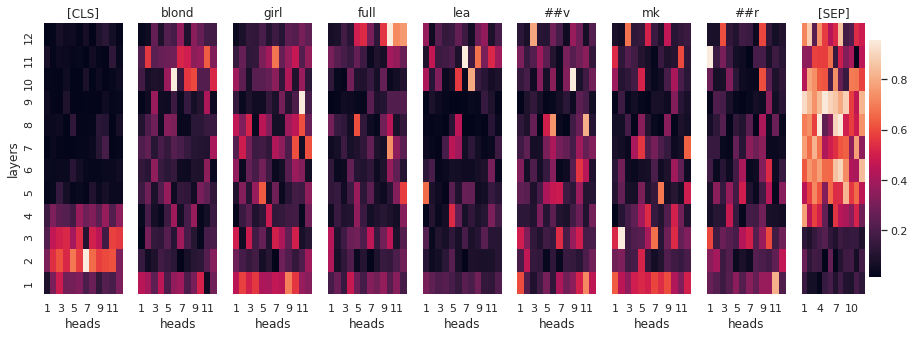

In [ ]:
# Create sentence and label lists
sentences = data_test_uncertain_correct_predictions["Text_clean"].values[-3]
sentences_tokenized, attention_list_per_sentence = get_model_attention_for_sentence(sentences,single_sentence=True)
attention_map_per_word_df = get_attention_map_per_word_as_df(sentences_tokenized, attention_list_per_sentence )
#generate_attention_heat_map_for_word("[CLS]", attention_map_per_word_df)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(figsize=(15,5),ncols=len(sentences_tokenized[0]))
#fig, axs = plt.subplots(ncols=len(sentences_tokenized[0]))
print(sentences_tokenized)
for i in sentences_tokenized[0]:
  print(i)
  res = generate_attention_attention_layers_per_head_for_word(i,attention_map_per_word_df)
  #print(res)
  indx = sentences_tokenized[0].index(i)
  if indx==0:
    sns.heatmap(res, ax=axs[indx], cbar=False)
    axs[indx].set_title(i)
    axs[indx].set(ylabel='layers',xlabel='heads')
    axs[indx].invert_yaxis()
  elif indx == (len(sentences_tokenized[0]) - 1):
    sns.heatmap(res,ax=axs[indx],annot=False, yticklabels=False,cbar=True)
    axs[indx].set_title(i)
    axs[indx].invert_yaxis()
  else:
    sns.heatmap(res,ax=axs[indx],annot=False, yticklabels=False,cbar=False )
    axs[indx].set_title(i)
    axs[indx].invert_yaxis()
    axs[indx].set(xlabel='heads')

## Attention weigth certain probability

In [ ]:
pd.set_option('display.max_colwidth', -1)
data_test_certain_predictions[["Text_clean","oh_label","BERT_fintuned_predictions_prob_1"]].values[2]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


array(['bet camper vote strateg least kat say mkr', 0.0,
       0.0057453033999999995], dtype=object)

[['[CLS]', 'kurdish', 'women', 'break', 'ever', '##i', 'sex', '##ist', 'law', 'islam', 'love', 'world', 'half', 'is', '##i', 'rep', '##ress', 'women', 'hate', '[SEP]']]
[CLS]
kurdish
women
break
ever
##i
sex
##ist
law
islam
love
world
half
is
##i
rep
##ress
women
hate
[SEP]


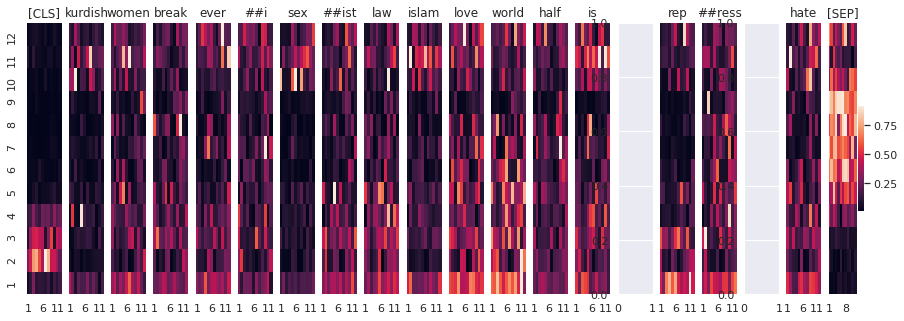

In [ ]:
import seaborn as sns; sns.set()
# Create sentence and label lists
sentences = data_test_certain_predictions["Text_clean"].values[2]
sentences_tokenized, attention_list_per_sentence = get_model_attention_for_sentence(sentences,single_sentence=True)
attention_map_per_word_df = get_attention_map_per_word_as_df(sentences_tokenized, attention_list_per_sentence )
#generate_attention_heat_map_for_word("[CLS]", attention_map_per_word_df)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(figsize=(15,5),ncols=len(sentences_tokenized[0]))
#fig, axs = plt.subplots(ncols=len(sentences_tokenized[0]))
print(sentences_tokenized)
for i in sentences_tokenized[0]:
  print(i)
  res = generate_attention_attention_layers_per_head_for_word(i,attention_map_per_word_df)
  indx = sentences_tokenized[0].index(i)
  if indx==0:
    sns.heatmap(res, ax=axs[indx], cbar=False)
    axs[indx].set_title(i)
    axs[indx].set(ylabel='layers',xlabel='heads')
    axs[indx].invert_yaxis()
  elif indx == (len(sentences_tokenized[0]) - 1):
    sns.heatmap(res,ax=axs[indx],annot=False, yticklabels=False,cbar=True)
    axs[indx].set_title(i)
    axs[indx].invert_yaxis()
  else:
    sns.heatmap(res,ax=axs[indx],annot=False, yticklabels=False,cbar=False )
    axs[indx].set_title(i)
    axs[indx].invert_yaxis()
    axs[indx].set(xlabel='heads')  

## attention weigth analysis of wrong prediction

In [ ]:
data_test_WRONG_predictions[["Text_clean","Text","oh_label","BERT_fintuned_predictions_prob_1","BERT_fintuned_predictions"]].values[4]

array(['ilivundrurb carolynneva link blasphemi',
       '@Audmum1 @ILivUndrUrBed @CarolynnEva You linked to BLASPHEMY!!!',
       1.0, 0.005068424, 0], dtype=object)

In [ ]:
data_test_WRONG_predictions[["Text_clean","Text","oh_label","BERT_predictions_prob_1","BERT_predictions"]].values[1]

array(['wateronatrain might like patriarchi',
       'RT @Wateronatrain: @MT8_9 You might like this http://t.co/c9m2pFmFJ3 #patriarchy',
       1.0, 0.49175483, 0], dtype=object)

[['[CLS]', 'il', '##iv', '##und', '##ru', '##rb', 'carolyn', '##ne', '##va', 'link', 'b', '##las', '##ph', '##emi', '[SEP]']]
[CLS]
il
##iv
##und
##ru
##rb
carolyn
##ne
##va
link
b
##las
##ph
##emi
[SEP]


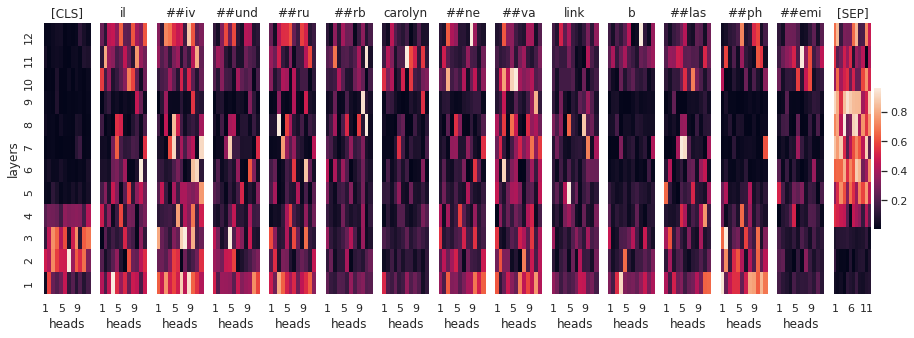

In [ ]:
# Create sentence and label lists
sentences = data_test_WRONG_predictions["Text_clean"].values[4]
sentences_tokenized, attention_list_per_sentence = get_model_attention_for_sentence(sentences,single_sentence=True)
attention_map_per_word_df = get_attention_map_per_word_as_df(sentences_tokenized, attention_list_per_sentence )
#generate_attention_heat_map_for_word("[CLS]", attention_map_per_word_df)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(figsize=(15,5),ncols=len(sentences_tokenized[0]))
#fig, axs = plt.subplots(ncols=len(sentences_tokenized[0]))
print(sentences_tokenized)
for i in sentences_tokenized[0]:
  print(i)
  res = generate_attention_attention_layers_per_head_for_word(i,attention_map_per_word_df)
  #print(res)
  indx = sentences_tokenized[0].index(i)
  if indx==0:
    sns.heatmap(res, ax=axs[indx], cbar=False)
    axs[indx].set_title(i)
    axs[indx].set(ylabel='layers',xlabel='heads')
    axs[indx].invert_yaxis()
  elif indx == (len(sentences_tokenized[0]) - 1):
    sns.heatmap(res,ax=axs[indx],annot=False, yticklabels=False,cbar=True)
    axs[indx].set_title(i)
    axs[indx].invert_yaxis()
  else:
    sns.heatmap(res,ax=axs[indx],annot=False, yticklabels=False,cbar=False )
    axs[indx].set_title(i)
    axs[indx].invert_yaxis()
    axs[indx].set(xlabel='heads')

## Attention weight analysis for correct prediction

In [ ]:
data_test_CORRECT_predictions[["Text_clean","Text","oh_label","BERT_fintuned_predictions"]].values[4]

array(['dude culinari school findawif notsexist',
       ':D @nkrause11 Dudes who go to culinary school: #why #findawife #notsexist :)',
       1.0, 1], dtype=object)

[['[CLS]', 'dude', 'cu', '##lina', '##ri', 'school', 'find', '##aw', '##if', 'not', '##se', '##xi', '##st', '[SEP]']]
[CLS]
dude
cu
##lina
##ri
school
find
##aw
##if
not
##se
##xi
##st
[SEP]


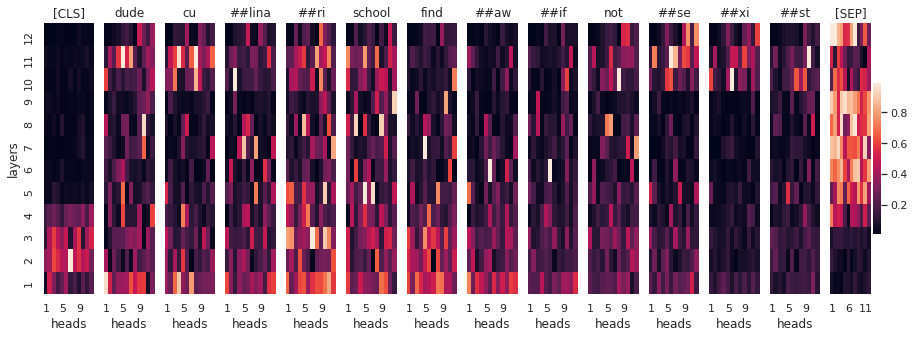

In [ ]:
# Create sentence and label lists
sentences = data_test_CORRECT_predictions["Text_clean"].values[4]
sentences_tokenized, attention_list_per_sentence = get_model_attention_for_sentence(sentences,single_sentence=True)
attention_map_per_word_df = get_attention_map_per_word_as_df(sentences_tokenized, attention_list_per_sentence )
#generate_attention_heat_map_for_word("[CLS]", attention_map_per_word_df)
import matplotlib.pyplot as plt
fig, axs = plt.subplots(figsize=(15,5),ncols=len(sentences_tokenized[0]))
#fig, axs = plt.subplots(ncols=len(sentences_tokenized[0]))
print(sentences_tokenized)
for i in sentences_tokenized[0]:
  print(i)
  res = generate_attention_attention_layers_per_head_for_word(i,attention_map_per_word_df)
  #print(res)
  indx = sentences_tokenized[0].index(i)
  if indx==0:
    sns.heatmap(res, ax=axs[indx], cbar=False)
    axs[indx].set_title(i)
    axs[indx].set(ylabel='layers',xlabel='heads')
    axs[indx].invert_yaxis()
  elif indx == (len(sentences_tokenized[0]) - 1):
    sns.heatmap(res,ax=axs[indx],annot=False, yticklabels=False,cbar=True)
    axs[indx].set_title(i)
    axs[indx].invert_yaxis()
  else:
    sns.heatmap(res,ax=axs[indx],annot=False, yticklabels=False,cbar=False )
    axs[indx].set_title(i)
    axs[indx].invert_yaxis()
    axs[indx].set(xlabel='heads')

## Attention weight for positive words in twitter sexism

In [ ]:
# Create sentence and label lists ['mkr', 'sexist', 'women', 'girl', 'kat']
sentences = data_test_text_contain_pos_words.Text_clean.sample(500).values
sentences_tokenized, attention_list_per_sentence = get_model_attention_for_sentence(sentences)
attention_map_per_word_df = get_attention_map_per_word_as_df(sentences_tokenized, attention_list_per_sentence )

In [ ]:
attention_map_per_word_df.to_csv("/content/drive/My Drive/Colab Notebooks/CB_Data/Twitter_sexism_BERT_with_otu_Fine_Tuning_most_pos_words_attetnion_weights")

In [ ]:
most_common_5_tp_tokenized = ["mk","##r","sex","##ist","women","girl","kat"]

['mk', '##r', 'sex', '##ist', 'women', 'girl', 'kat']
mk
##r
sex
##ist
women
girl
kat


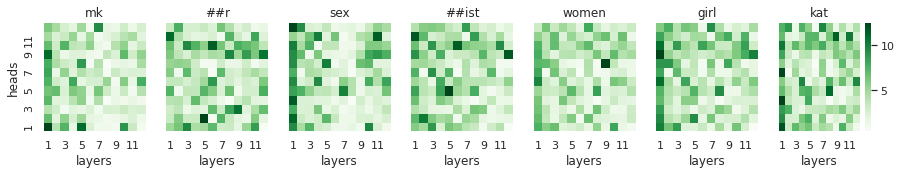

In [ ]:
# Create sentence and label lists
import matplotlib.pyplot as plt
fig, axs = plt.subplots(figsize=(15,2),ncols=len(most_common_5_tp_tokenized))
#fig, axs = plt.subplots(ncols=len(sentences_tokenized[0]))
print(most_common_5_tp_tokenized)
for i in most_common_5_tp_tokenized:
  print(i)
  res = generate_attention_attention_layers_per_head_for_word(i,attention_map_per_word_df).transpose()

  #print(res)
  indx = most_common_5_tp_tokenized.index(i)
  if indx==0:
    sns.heatmap(res, ax=axs[indx], cbar=False, cmap="Greens")
    axs[indx].set_title(i)
    axs[indx].set(ylabel='heads',xlabel='layers')
    axs[indx].invert_yaxis()
  elif indx == (len(most_common_5_tp_tokenized) - 1):
    sns.heatmap(res,ax=axs[indx],annot=False, yticklabels=False,cbar=True, cmap="Greens")
    axs[indx].set_title(i)
    axs[indx].invert_yaxis()
    axs[indx].set(xlabel='layers')
  else:
    sns.heatmap(res,ax=axs[indx],annot=False, yticklabels=False,cbar=False , cmap="Greens")
    axs[indx].set_title(i)
    axs[indx].invert_yaxis()
    axs[indx].set(xlabel='layers')

['mk', '##r', 'sex', '##ist', 'women', 'girl', 'kat']
mk
##r
sex
##ist
women
girl
kat


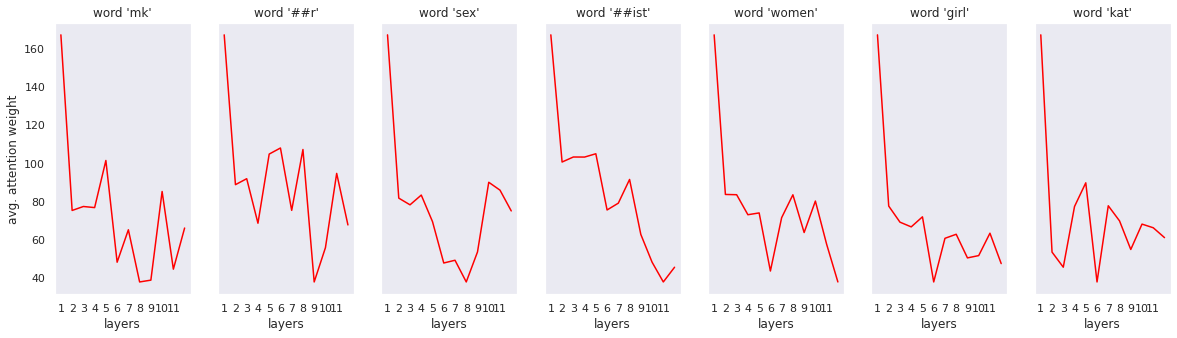

In [ ]:
# Create sentence and label lists
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=1, ncols=len(most_common_5_tp_tokenized), figsize=(15, 2))
#fig, axs = plt.subplots(ncols=len(sentences_tokenized[0]))
print(most_common_5_tp_tokenized)
for i in most_common_5_tp_tokenized:
  layers = []
  print(i)
  res = generate_attention_attention_layers_per_head_for_word(i,attention_map_per_word_df)
  avg_head_res = res.mean(axis=1).values
  layers = res.index.values
  #print(res)
  indx = most_common_5_tp_tokenized.index(i)
  if indx==0:
    axs[indx].set_title("word '"+str(i)+"'")
    axs[indx].set_xticks(np.arange(12))
    axs[indx].set_xlabel("layers")
    axs[indx].set_ylabel("avg. attention weight")
    axs[indx].plot(layers,avg_head_res,color = 'green')
    axs[indx].grid(False)
  
  else:
    axs[indx].set_title("word '"+str(i)+"'")
    axs[indx].set_yticks([])
    axs[indx].set_xlabel("layers")
    axs[indx].set_xticks(np.arange(12))
    axs[indx].set_ylabel("")
    axs[indx].plot(layers,avg_head_res,color = 'green')
    axs[indx].grid(False)


## attention map of the special tokens

['[CLS]', '[SEP]']
[CLS]
[SEP]


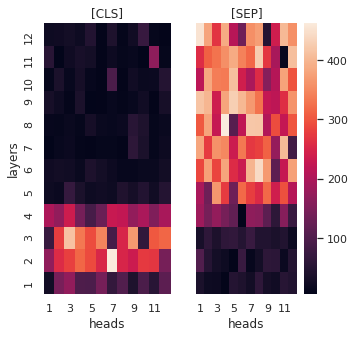

In [ ]:
# Create sentence and label lists
import matplotlib.pyplot as plt
special_tokens = ["[CLS]","[SEP]"]
fig, axs = plt.subplots(figsize=(5,5),ncols=len(special_tokens))
#fig, axs = plt.subplots(ncols=len(sentences_tokenized[0]))
print(special_tokens)
for i in special_tokens:
  print(i)
  res = generate_attention_attention_layers_per_head_for_word(i,attention_map_per_word_df)
  #print(res)
  indx = special_tokens.index(i)
  if indx==0:
    sns.heatmap(res, ax=axs[indx], cbar=False)
    axs[indx].set_title(i)
    axs[indx].set(ylabel='layers',xlabel='heads')
    axs[indx].invert_yaxis()
  elif indx == (len(special_tokens) - 1):
    sns.heatmap(res,ax=axs[indx],annot=False, yticklabels=False,cbar=True)
    axs[indx].set_title(i)
    axs[indx].invert_yaxis()
    axs[indx].set(xlabel='heads')
  else:
    sns.heatmap(res,ax=axs[indx],annot=False, yticklabels=False,cbar=False )
    axs[indx].set_title(i)
    axs[indx].invert_yaxis()
    axs[indx].set(xlabel='heads')

['[CLS]', '[SEP]']
[CLS]
[SEP]


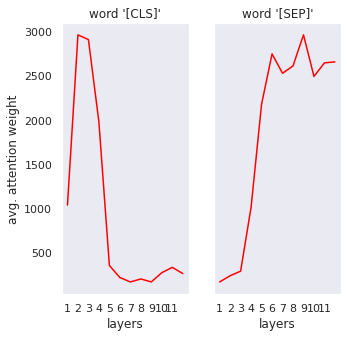

In [ ]:
# Create sentence and label lists
import matplotlib.pyplot as plt
special_tokens = ["[CLS]","[SEP]"]
fig, axs = plt.subplots(nrows=1, ncols=len(special_tokens), figsize=(5, 5))
#fig, axs = plt.subplots(ncols=len(sentences_tokenized[0]))
print(special_tokens)
for i in special_tokens:
  layers = []
  print(i)
  res = generate_attention_attention_layers_per_head_for_word(i,attention_map_per_word_df)
  avg_head_res = res.sum(axis=1).values
  layers = res.index.values
  #print(res)
  indx = special_tokens.index(i)
  if indx==0:
    axs[indx].set_title("word '"+str(i)+"'")
    axs[indx].set_xticks(np.arange(12))
    axs[indx].set_xlabel("layers")
    axs[indx].set_ylabel("avg. attention weight")
    axs[indx].plot(layers,avg_head_res,color = 'red')
    axs[indx].grid(False)
  
  else:
    axs[indx].set_title("word '"+str(i)+"'")
    axs[indx].set_yticks([])
    axs[indx].set_xlabel("layers")
    axs[indx].set_xticks(np.arange(12))
    axs[indx].set_ylabel("")
    axs[indx].plot(layers,avg_head_res,color = 'red')
    axs[indx].grid(False)


## attention weigth for negative words pattern in twitter sexism

In [ ]:
sentences_tn = data_test_text_contain_neg_words.Text_clean.sample(500).values
sentences_tokenized_tn, attention_list_per_sentence_tn = get_model_attention_for_sentence(sentences_tn)


In [ ]:
attention_map_per_word_tn_df = get_attention_map_per_word_as_df(sentences_tokenized_tn, attention_list_per_sentence_tn )

In [ ]:
attention_map_per_word_tn_df.to_csv("/content/drive/My Drive/Colab Notebooks/CB_Data/Twitter_sexism_BERT_with_otu_Fine_Tuning_most_NEG_words_attetnion_weights")

['mk', '##r', 'kat', 'like', 'get', 'and', '##r']
mk
##r
kat
like
get
and
##r


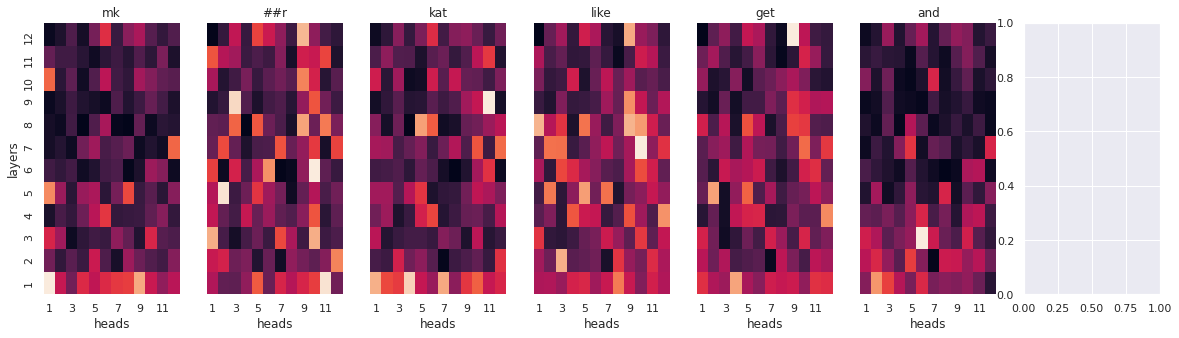

In [ ]:
# Create sentence and label lists
most_common_5_tn_tokenized =  ["mk","##r","kat","like","get","and","##r"]
import matplotlib.pyplot as plt
fig, axs = plt.subplots(figsize=(20,5),ncols=len(most_common_5_tn_tokenized))
#fig, axs = plt.subplots(ncols=len(sentences_tokenized[0]))
print(most_common_5_tn_tokenized)
for i in most_common_5_tn_tokenized:
  print(i)
  res = generate_attention_attention_layers_per_head_for_word(i,attention_map_per_word_tn_df)
  #print(res)
  indx = most_common_5_tn_tokenized.index(i)
  if indx==0:
    sns.heatmap(res, ax=axs[indx], cbar=False)
    axs[indx].set_title(i)
    axs[indx].set(ylabel='layers',xlabel='heads')
    axs[indx].invert_yaxis()
  elif indx == (len(most_common_5_tn_tokenized) - 1):
    sns.heatmap(res,ax=axs[indx],annot=False, yticklabels=False,cbar=True)
    axs[indx].set_title(i)
    axs[indx].invert_yaxis()
    axs[indx].set(xlabel='heads')
  else:
    sns.heatmap(res,ax=axs[indx],annot=False, yticklabels=False,cbar=False )
    axs[indx].set_title(i)
    axs[indx].invert_yaxis()
    axs[indx].set(xlabel='heads')

['mk', '##r', 'kat', 'like', 'get', 'and', '##r']
mk
##r
kat
like
get
and
##r


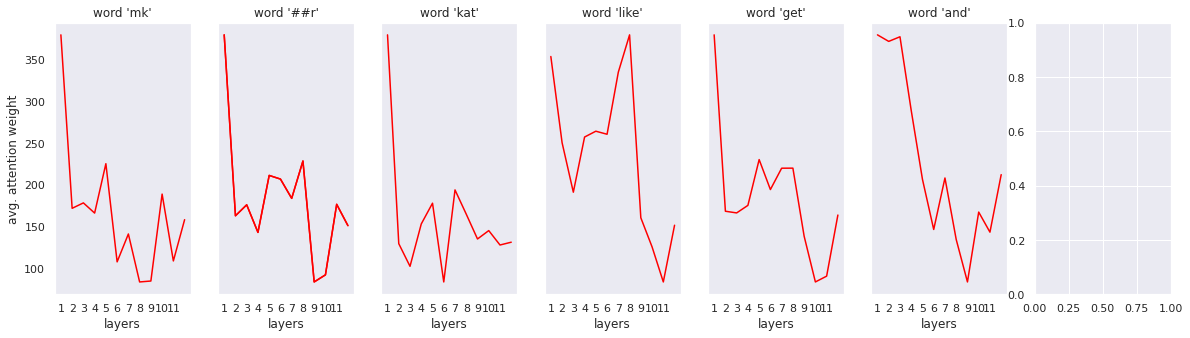

In [ ]:
# Create sentence and label lists
import matplotlib.pyplot as plt
most_common_5_tn_tokenized =  ["mk","##r","kat","like","get","and","##r"]
fig, axs = plt.subplots(nrows=1, ncols=len(most_common_5_tn_tokenized), figsize=(20, 5))
#fig, axs = plt.subplots(ncols=len(sentences_tokenized[0]))
print(most_common_5_tn_tokenized)
for i in most_common_5_tn_tokenized:
  layers = []
  print(i)
  res = generate_attention_attention_layers_per_head_for_word(i,attention_map_per_word_tn_df)
  avg_head_res = res.sum(axis=1).values
  layers = res.index.values
  #print(res)
  indx = most_common_5_tn_tokenized.index(i)
  if indx==0:
    axs[indx].set_title("word '"+str(i)+"'")
    axs[indx].set_xticks(np.arange(12))
    axs[indx].set_xlabel("layers")
    axs[indx].set_ylabel("avg. attention weight")
    axs[indx].plot(layers,avg_head_res,color = 'red')
    axs[indx].grid(False)
  
  else:
    axs[indx].set_title("word '"+str(i)+"'")
    axs[indx].set_yticks([])
    axs[indx].set_xlabel("layers")
    axs[indx].set_xticks(np.arange(12))
    axs[indx].set_ylabel("")
    axs[indx].plot(layers,avg_head_res,color = 'red')
    axs[indx].grid(False)
